
# Unsupervised Clustering & ANN on Medical (Heart) Data

**Pipeline:** Preprocessing → Feature Engineering → (Optional) Feature Selection → Clustering (KMeans & DBSCAN) → Metrics (Silhouette, DBI) → PCA 2D → ANN via Annoy.

**Landasan (ringkas):**
- Imputasi median/mode; scaling **StandardScaler**
- **KMeans** (k-means++), **K** via **Silhouette**
- **DBSCAN**: **eps** via **k-distance elbow**; **min_samples ≥ D+1** atau ~**2·D**
- Evaluasi: **Silhouette** (↑ lebih baik), **DBI** (↓ lebih baik)
- **Annoy** untuk nearest neighbors pada fitur terstandarisasi


## 0) Environment (Colab)
Jalankan sekali untuk memasang Annoy.

In [3]:

!pip install annoy --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## 1) Load Dataset

In [5]:

import os, pandas as pd, numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter

dataset_handle = "johnsmith88/heart-disease-dataset"
file_path = "heart.csv"

print(f"Memuat '{file_path}' dari Kaggle: '{dataset_handle}'...")

df_raw = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_handle,
  file_path,
)

display(df_raw.head())
print("\n== DTypes =="); print(df_raw.dtypes)
print("\n== Missing Values =="); print(df_raw.isna().sum().sort_values(ascending=False))


Memuat 'heart.csv' dari Kaggle: 'johnsmith88/heart-disease-dataset'...


/tmp/ipython-input-4023132261.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_raw = kagglehub.load_dataset(


Using Colab cache for faster access to the 'heart-disease-dataset' dataset.


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



== DTypes ==
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

== Missing Values ==
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64



## 2) Preprocessing
- Imputasi: median (numerik) & modus (kategorikal)
- OneHot (drop_first) untuk kategori
- StandardScaler untuk fitur numerik hasil transformasi


In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = df_raw.copy()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_imputer, num_cols),
        ("cat", Pipeline(steps=[("imputer", cat_imputer), ("ohe", ohe)]), cat_cols)
    ],
    remainder="drop"
)
X_imputed = preprocess.fit_transform(df)
num_names = num_cols
cat_names = list(preprocess.named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(cat_cols)) if len(cat_cols)>0 else []
feature_names = num_names + cat_names
import pandas as pd, numpy as np
X_imp_df = pd.DataFrame(X_imputed, columns=feature_names, index=df.index)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp_df)
X = pd.DataFrame(X_scaled, columns=feature_names, index=df.index)

print("After preprocessing:", X.shape)
display(X.head())

After preprocessing: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,-1.026698
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,-1.026698
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,-1.026698
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,-1.026698
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,-1.026698



## 3) Feature Engineering (≥ 3 fitur)
- `CholAge = chol × age`
- `AgeOldpeak = age × oldpeak`
- `HRReserve = thalach / (220 − age)`
Hanya ditambahkan jika kolom sumber tersedia.


In [8]:

X_fe = X.copy()
X_unscaled = X_imp_df.copy()
engineered = []

lower_cols = [c.lower() for c in X_unscaled.columns]

def add_feat(name, arr):
    import numpy as np
    X_fe[name] = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)

# 1) CholAge
if "chol" in lower_cols and "age" in lower_cols:
    chol = X_unscaled[[c for c in X_unscaled.columns if c.lower()=="chol"][0]].to_numpy().ravel()
    age  = X_unscaled[[c for c in X_unscaled.columns if c.lower()=="age"][0]].to_numpy().ravel()
    add_feat("CholAge", chol*age); engineered.append("CholAge")

# 2) AgeOldpeak
if "age" in lower_cols and "oldpeak" in lower_cols:
    age  = X_unscaled[[c for c in X_unscaled.columns if c.lower()=="age"][0]].to_numpy().ravel()
    op   = X_unscaled[[c for c in X_unscaled.columns if c.lower()=="oldpeak"][0]].to_numpy().ravel()
    add_feat("AgeOldpeak", age*op); engineered.append("AgeOldpeak")

# 3) HRReserve
if "thalach" in lower_cols and "age" in lower_cols:
    th   = X_unscaled[[c for c in X_unscaled.columns if c.lower()=="thalach"][0]].to_numpy().ravel()
    age  = X_unscaled[[c for c in X_unscaled.columns if c.lower()=="age"][0]].to_numpy().ravel()
    denom = (220.0 - age)
    denom[denom==0] = np.nan
    add_feat("HRReserve", th/denom); engineered.append("HRReserve")

print("Engineered features:", engineered)
display(X_fe.head())


Engineered features: ['CholAge', 'AgeOldpeak', 'HRReserve']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge,AgeOldpeak,HRReserve
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,-1.026698,11024.0,52.0,1.000000
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,-1.026698,10759.0,164.3,0.928144
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,-1.026698,12180.0,182.0,0.833333
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,-1.026698,12383.0,0.0,1.012579
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,-1.026698,18228.0,117.8,0.670886



## 4) (Opsional) Feature Selection
- VarianceThreshold (≈ konstan → drop)
- Correlation pruning (|corr| ≥ 0.95 → drop salah satu)


In [9]:

from sklearn.feature_selection import VarianceThreshold
import numpy as np, pandas as pd

X_sel = X_fe.copy()
vt = VarianceThreshold(threshold=1e-4)
X_v = vt.fit_transform(X_sel)
kept = vt.get_support()
X_sel = pd.DataFrame(X_v, columns=np.array(X_sel.columns)[kept], index=X_sel.index)

corr = pd.DataFrame(X_sel, columns=X_sel.columns).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] >= 0.95)]
X_sel = X_sel.drop(columns=to_drop, errors="ignore")

print("Dropped (high corr):", to_drop)
print("Final features:", X_sel.shape)
display(X_sel.head())


Dropped (high corr): ['AgeOldpeak']
Final features: (1025, 16)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,CholAge,HRReserve
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,-1.026698,11024.0,1.000000
1,-0.158157,0.661504,-0.915755,0.479107,-0.833861,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,-1.026698,10759.0,0.928144
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,-1.026698,12180.0,0.833333
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,-1.026698,12383.0,1.012579
4,0.834359,-1.511706,-0.915755,0.364875,0.930822,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,-1.026698,18228.0,0.670886


## 5) KMeans — pilih K via Silhouette (K=2..8)

In [10]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

Xc = X_sel.values
best_k, best_sil = None, -1
sil_per_k = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = km.fit_predict(Xc)
    sil = silhouette_score(Xc, labels)
    sil_per_k[k] = sil
    if sil > best_sil:
        best_sil, best_k = sil, k

print("Silhouette per K:", sil_per_k)
print("Best K:", best_k, "Silhouette:", round(best_sil, 4))

kmeans = KMeans(n_clusters=best_k, init="k-means++", n_init=25, random_state=42)
km_labels = kmeans.fit_predict(Xc)
km_sil = silhouette_score(Xc, km_labels)
km_dbi = davies_bouldin_score(Xc, km_labels)
print(f"KMeans → Silhouette={km_sil:.4f} | DBI={km_dbi:.4f}")


Silhouette per K: {2: np.float64(0.5614305446827021), 3: np.float64(0.535452927847684), 4: np.float64(0.527429474630901), 5: np.float64(0.5526268853375899), 6: np.float64(0.5554641972713873), 7: np.float64(0.5692837859741381), 8: np.float64(0.5626885535916094)}
Best K: 7 Silhouette: 0.5693
KMeans → Silhouette=0.5690 | DBI=0.4117


## 6) DBSCAN — eps via k-distance elbow; min_samples ≥ D+1 atau ≈ 2·D

In [11]:

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np

D = X_sel.shape[1]
min_samples = max(D+1, 2*D)

nbrs = NearestNeighbors(n_neighbors=min_samples).fit(Xc)
distances, _ = nbrs.kneighbors(Xc)
k_dists = np.sort(distances[:, -1])

d1 = np.gradient(k_dists)
d2 = np.gradient(d1)
elbow_idx = int(np.argmax(d2)) if len(d2)>0 else int(0.9*len(k_dists))
eps = float(k_dists[elbow_idx])

print(f"Estimated eps: {eps:.5f} | min_samples={min_samples} | D={D}")

dbs = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
db_labels = dbs.fit_predict(Xc)
uniq = np.unique(db_labels)
print("DBSCAN unique labels:", uniq)

if len(uniq)>1 and np.any(db_labels!=-1):
    from sklearn.metrics import silhouette_score, davies_bouldin_score
    try:
        db_sil = silhouette_score(Xc, db_labels)
        db_dbi = davies_bouldin_score(Xc, db_labels)
        print(f"DBSCAN → Silhouette={db_sil:.4f} | DBI={db_dbi:.4f}")
    except Exception as e:
        print("DBSCAN metrics skipped:", e)
else:
    print("DBSCAN did not form valid >1 clusters; metrics skipped.")


Estimated eps: 6305.00234 | min_samples=32 | D=16
DBSCAN unique labels: [-1  0]
DBSCAN → Silhouette=0.8140 | DBI=0.1235


## 7) Visualisasi PCA 2D

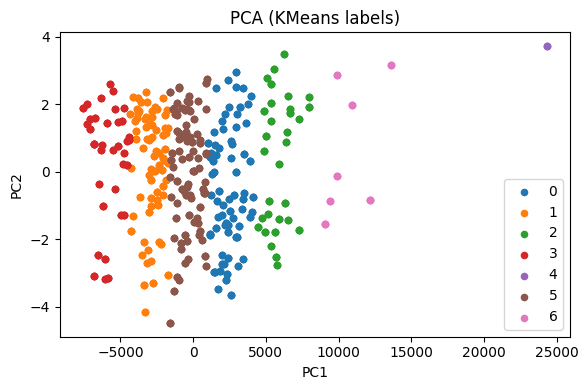

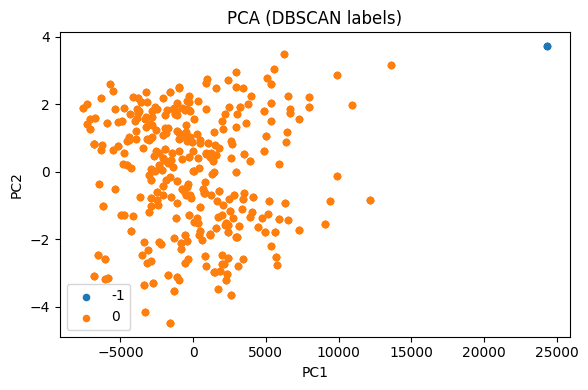

In [12]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(Xc)

def plot_scatter(XY, labels, title):
    plt.figure(figsize=(6,4))
    for lab in np.unique(labels):
        m = labels==lab
        plt.scatter(XY[m,0], XY[m,1], label=str(lab), s=20)
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(); plt.tight_layout(); plt.show()

plot_scatter(XY, km_labels, "PCA (KMeans labels)")
plot_scatter(XY, db_labels, "PCA (DBSCAN labels)")


## 8) ANN dengan Annoy (5 query × 10 neighbors)

In [13]:

import numpy as np, pandas as pd
try:
    from annoy import AnnoyIndex
    ANN_AVAILABLE = True
except Exception as e:
    ANN_AVAILABLE = False
    print("Annoy not available; install with pip in Colab.")

num_dim = X_sel.shape[1]
metric = 'euclidean'

if ANN_AVAILABLE:
    n_trees = 30
    t = AnnoyIndex(num_dim, metric)
    for i in range(X_sel.shape[0]):
        t.add_item(i, X_sel.iloc[i].astype(float).values.tolist())
    t.build(n_trees)

    rng = np.random.default_rng(42)
    query_points = rng.choice(np.arange(X_sel.shape[0]), size=min(5, X_sel.shape[0]), replace=False)
    rows = []
    for q in query_points:
        idxs, dists = t.get_nns_by_item(int(q), 10, search_k=-1, include_distances=True)
        rows.append({"query_index": int(q), "neighbors": idxs, "distances": [float(d) for d in dists]})
    ann_df = pd.DataFrame(rows)
    display(ann_df)
else:
    print("Skipping Annoy in this environment.")


,query_index,neighbors,distances
0,790,"[174, 790, 791, 892, 498, 823, 923, 94, 795, 814]","[0.0, 0.0, 0.0, 0.0, 4.654543876647949, 4.6545..."
1,449,"[449, 731, 803, 860, 111, 805, 938, 54, 55, 613]","[0.0, 0.0, 0.0, 0.0, 18.633081436157227, 18.63..."
2,669,"[323, 345, 669, 349, 600, 895, 951, 193, 455, ...","[0.0, 0.0, 0.0, 70.21124267578125, 70.21124267..."
3,91,"[91, 200, 418, 527, 105, 250, 467, 1022, 268, ...","[0.0, 0.0, 0.0, 0.0, 33.452232360839844, 33.45..."
4,443,"[427, 443, 491, 144, 662, 1019, 139, 655, 867,...","[0.0, 0.0, 0.0, 12.557770729064941, 12.5577707..."


## 9) Rekap & Simpan Label

In [14]:

import numpy as np, pandas as pd, json

recap = {
    "best_k": int(best_k),
    "kmeans_silhouette": float(km_sil),
    "kmeans_davies_bouldin": float(km_dbi),
    "dbscan_eps": float(eps),
    "dbscan_min_samples": int(max(X_sel.shape[1]+1, 2*X_sel.shape[1])),
    "dbscan_unique_labels": [int(x) for x in np.unique(db_labels)]
}
print(json.dumps(recap, indent=2))

labels_df = pd.DataFrame({"kmeans_label": km_labels, "dbscan_label": db_labels}, index=df_raw.index)
labels_df.to_csv("cluster_labels.csv", index=False)
print("Saved cluster_labels.csv")


{
  "best_k": 7,
  "kmeans_silhouette": 0.5689963938545471,
  "kmeans_davies_bouldin": 0.4117419341782016,
  "dbscan_eps": 6305.002344207012,
  "dbscan_min_samples": 32,
  "dbscan_unique_labels": [
    -1,
    0
  ]
}
Saved cluster_labels.csv
